<a href="https://colab.research.google.com/github/ajitaravind/RAGAS-evaluation/blob/main/RAGEvalUsingRagas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
%%capture
pip install langchain langchain_core langchain_community ragas langchain_openai langchain_nomic langchain-cohere

In [37]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://blog.langchain.dev/langgraph-multi-agent-workflows/")
docs = loader.load()

In [38]:
from langchain.docstore.document import Document

In [39]:
def remove_unessesary_lines(docs):
    lines = ""
    for doc in docs:
            lines += doc.page_content
    new_lines = lines.split("\n")
    stripped_lines = [line.strip() for line in new_lines]
    non_empty_lines = [line for line in stripped_lines if line]
    cleaned_content = "".join(non_empty_lines)
    return cleaned_content

cleaned_content = remove_unessesary_lines(docs)

#converting to a Document format for embedding
new_doc = [Document(page_content=cleaned_content,metadata =docs[0].metadata)]

In [40]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.split_documents(new_doc)

In [41]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["NOMIC_API_KEY"] = userdata.get('NOMIC_API_KEY')
os.environ["COHERE_API_KEY"] = userdata.get('COHERE_API_KEY')

In [42]:
# RAGAS expects a file_name dict as key
for document in chunks:
    document.metadata['file_name'] = document.metadata['source']

In [43]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_cohere import ChatCohere

In [44]:
generator_llm = ChatOpenAI(model="gpt-3.5-turbo-16k")
critic_llm = ChatCohere()
embeddings = NomicEmbeddings(model="nomic-embed-text-v1.5")

In [45]:
generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

In [46]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ragaseval"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

In [47]:
testset = generator.generate_with_langchain_docs(chunks, test_size=2, distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

embedding nodes:   0%|          | 0/42 [00:00<?, ?it/s]

Generating:   0%|          | 0/2 [00:00<?, ?it/s]

In [48]:
testset.to_pandas()

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What's the deal with routers operating based o...,[format inputs in a specific way with a specif...,The router is the component that mainly contro...,reasoning,[{'source': 'https://blog.langchain.dev/langgr...,True


In [49]:
%%capture
pip install chromadb

In [50]:
from langchain_openai.embeddings import OpenAIEmbeddings

from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI

embedding = OpenAIEmbeddings()
model = ChatOpenAI()

vectorstore = Chroma.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [51]:
from langchain_core.prompts import PromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context","question"]
  )

In [52]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": retriever,  "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [53]:
questions = testset.to_pandas()["question"].to_list()
ground_truth = testset.to_pandas()["ground_truth"].to_list()

In [54]:
questions

["What's the deal with routers operating based on sys msg and tool relationship?"]

In [55]:
from datasets import Dataset

questions = testset.to_pandas()["question"].to_list()
ground_truth = testset.to_pandas()["ground_truth"].to_list()

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(rag_chain.invoke(query))
    data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

dataset = Dataset.from_dict(data)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [56]:
dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 1
})

In [57]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset,
    metrics=[
        context_relevancy,
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

In [58]:
result.to_pandas()

,question,answer,contexts,ground_truth,context_relevancy,context_precision,context_recall,faithfulness,answer_relevancy
0,What's the deal with routers operating based o...,The routers operate based on system messages a...,[format inputs in a specific way with a specif...,The router is the component that mainly contro...,0.0,1.0,1.0,1.0,0.770274


In [59]:
%%capture
pip install seaborn

In [60]:
%%capture
pip install matplotlib

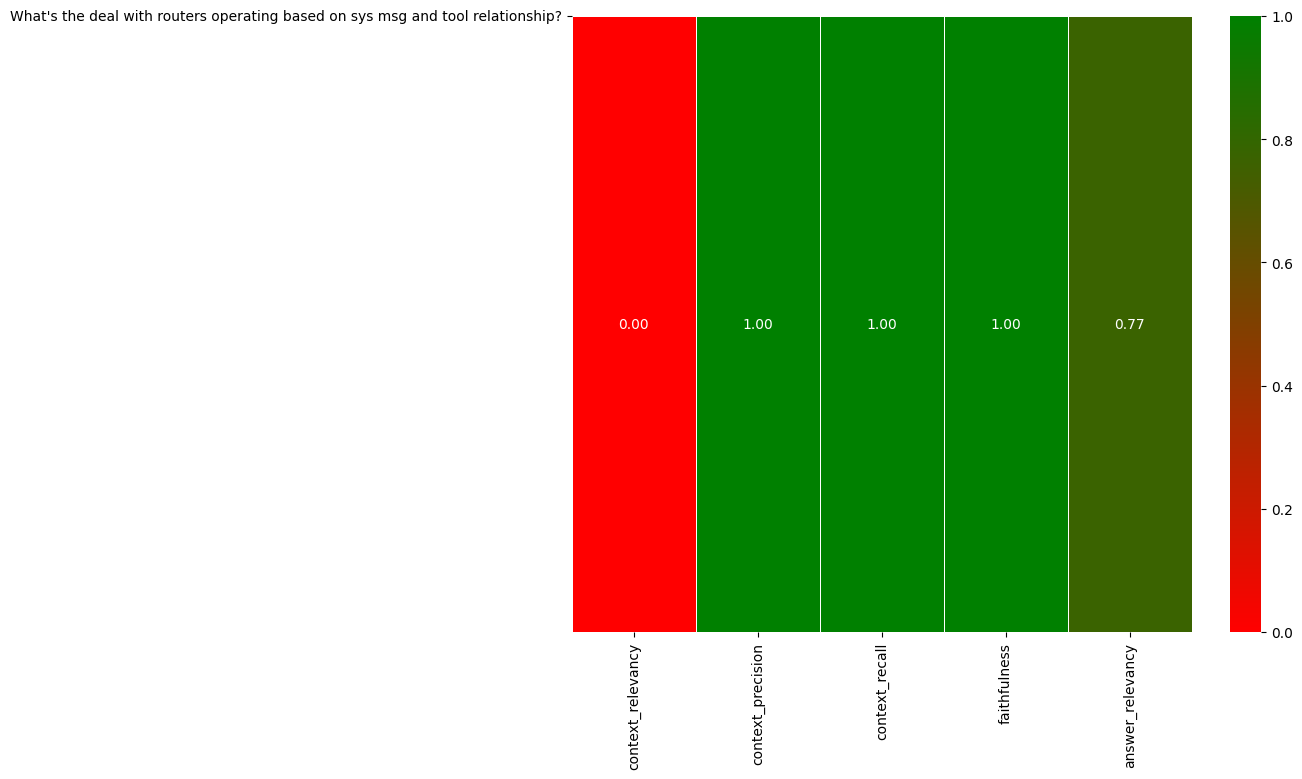

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[['context_relevancy', 'context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()